In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
  
from ucimlrepo import fetch_ucirepo

abalone = fetch_ucirepo(id = 1)
print(abalone.variables)

data = abalone.data.original.to_numpy()

# Getting rid of observations with 0 height, or with a height too large (as specified in the first report)
data = data[data[:, 3] != 0]
data = data[data[:, 3] < 0.5]
        
print(np.shape(data))

             name     role         type demographic  \
0             Sex  Feature  Categorical        None   
1          Length  Feature   Continuous        None   
2        Diameter  Feature   Continuous        None   
3          Height  Feature   Continuous        None   
4    Whole_weight  Feature   Continuous        None   
5  Shucked_weight  Feature   Continuous        None   
6  Viscera_weight  Feature   Continuous        None   
7    Shell_weight  Feature   Continuous        None   
8           Rings   Target      Integer        None   

                   description  units missing_values  
0         M, F, and I (infant)   None             no  
1    Longest shell measurement     mm             no  
2      perpendicular to length     mm             no  
3           with meat in shell     mm             no  
4                whole abalone  grams             no  
5               weight of meat  grams             no  
6  gut weight (after bleeding)  grams             no  
7        

- - -
- - -
# 1. Regression (part 1)

## 1.1. Data preparation
> **Exercise**
> 
> Explain what variable is predicted based on which other variables and what you hope to accomplish by the regression. 
> Mention your feature transformation choices such as one-of-K coding. 
> Since we will use regularization momentarily, apply a feature transformation to your data matrix X such that each column has mean $0$ and standard deviation $1$.

### 1.1.1. Objective


### 1.1.2. One-hot encoding
We decided to use the one-hot encoding to transform the first attribute, which is the gender of the abalone: intially assuming values 'M', 'F', and 'I' for male, female, and infant, we encode the values by replacing the column with three different columns, one for each gender, in which the values are 1 if the original value was the gender, and 0 otherwise.

In [2]:
def encode_sex_column(data):
    # Extract sex column
    sex_column = data[:, 0]
    
    # convert to 0 and 1
    male = (sex_column == 'M').astype(int)
    female = (sex_column == 'F').astype(int)
    infant = (sex_column == 'I').astype(int)
    
    # Stack horizontally
    encoded = np.column_stack((male, female, infant))
    
    # Combine with rest of data (excluding original sex column)
    encoded_data = np.column_stack((encoded, data[:, 1:]))
    
    return encoded_data

### 1.1.3. Data standardization
We also need to standardize the data to have mean 0 and standard deviation 1.

In [3]:
def standardize_data(data):
    # Keep one-hot encoded columns unchanged
    encoded_cols = data[:, :3]
    
    # Standardize remaining columns
    numeric_cols = data[:, 3:].astype(float)
    
    # Calculate mean and std for each column
    means = np.mean(numeric_cols, axis=0)
    stds = np.std(numeric_cols, axis=0)
    
    # Standardize: (X - mean) / std
    standardized_cols = (numeric_cols - means) / stds
    
    # Combine back with encoded columns
    standardized_data = np.column_stack((encoded_cols, standardized_cols))
    
    return standardized_data, means, stds

In [4]:
encoded_data = encode_sex_column(data)
standardized_data, _, _ = standardize_data(encoded_data)
X, y = standardized_data[:, :-1], standardized_data[:, -1:]

print(f'Input:\n{X}\n\nOutput:\n{y}')

Input:
[[1 0 0 ... -0.6081055225612073 -0.7268164552421242 -0.6380910895920106]
 [1 0 0 ... -1.171985955468598 -1.2062173456712297 -1.2129896603076291]
 [0 1 0 ... -0.4637521317369153 -0.3569929111968146 -0.20691716155529657]
 ...
 [1 0 0 ... 0.7497185598797895 0.9761981364726973 0.4973335875713363]
 [0 1 0 ... 0.7745292989277149 0.7342148298751492 0.4110988019639934]
 [1 0 0 ... 2.6443568144486225 1.7888967888191807 1.841158996619095]]

Output:
[[1.5706318427842865]
 [-0.9103927355970242]
 [-0.2901365910016965]
 ...
 [-0.2901365910016965]
 [0.01999148129596736]
 [0.640247625891295]]


### 1.1.4. Linear regression
We now implement a basic linear regression model that can solve analytically for the weights.

In [5]:
class LinearRegression:
    def __init__(self, X, y,include_bias=True):
        if not include_bias:
            self.X = X.astype(np.float64)
        else:
            self.X = np.concatenate((np.ones((X.shape[0], 1)), X.astype(np.float64)), axis=1) # add bias weight as first column
        self.y = y.astype(np.float64)
        self.weights = None
        
    def solve_analytical(self):
        XtX = np.dot(self.X.T, self.X)
        Xty = np.dot(self.X.T, self.y)
        
        self.weights = np.linalg.solve(XtX, Xty)
        
    def predict(self):
        return np.dot(self.X, self.weights)
    
    def score(self):
        y_pred = self.predict()
        
        ss_total = np.sum((self.y - np.mean(self.y)) ** 2)
        ss_residual = np.sum((self.y - y_pred) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        
        mse = np.mean((self.y - y_pred) ** 2)
        
        return {'R2': r2, 'MSE': mse}

In [6]:
model = LinearRegression(X, y)
model.solve_analytical()
scores = model.score()

print(f"R² Score: {scores['R2']:.4f}")
print(f"MSE: {scores['MSE']:.4f}")

R² Score: 0.5439
MSE: 0.4561


- - -
## 1.2. Regularization

### 1.2.1. Analytical solution
First we have to update the method that solves the linear system to include the regularization term.

In [7]:
def solve_analytical(self, lambda_=0.0):
    n_features = self.X.shape[1]
    identity = np.eye(n_features)
    identity[0, 0] = 0  # Do not regularize the bias term

    
    XtX = np.dot(self.X.T, self.X)
    XtX_reg = XtX + lambda_ * identity
    Xty = np.dot(self.X.T, self.y)
    
    self.weights = np.linalg.solve(XtX_reg, Xty)   
    
LinearRegression.solve_analytical = solve_analytical

In [8]:
model = LinearRegression(X, y)
model.solve_analytical(lambda_=10)
scores = model.score()

print(f"R² Score: {scores['R2']:.4f}")
print(f"MSE: {scores['MSE']:.4f}")

R² Score: 0.5426
MSE: 0.4574


### 1.2.2. Regularization path
Then we can write a method for plotting the mean coefficient values, which shows the weights of each feature as a function of the regularization parameter.

In [9]:
def plot_regularization_effects(self, lambda_range, n_samples):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    lambdas = np.logspace(lambda_range[0], lambda_range[1], n_samples) 

    # Plot 1: Regularization Path
    paths = []
    for lambda_ in lambdas:
        self.solve_analytical(lambda_)
        paths.append(self.weights.flatten())

    paths = np.array(paths)
    for i in range(paths.shape[1]):
        ax1.semilogx(lambdas, paths[:, i], '-', label='Bias Term' if i == 0 else f'Feature {i}')
    
    ax1.set_xlabel('λ (Regularization Parameter)')
    ax1.set_ylabel('Weight Value')
    ax1.set_title('Weight Values vs Regularization λ')
    ax1.grid(True, which="both", ls="-", alpha=0.2)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 2: Model Performance
    r2_scores = []
    mse_scores = []
    for lambda_ in lambdas:
        self.solve_analytical(lambda_)
        scores = self.score()
        r2_scores.append(scores['R2'])
        mse_scores.append(scores['MSE'])
    
    # Plot R² score
    ax2.semilogx(lambdas, r2_scores, 'b-', label='R² Score')
    ax2.set_xlabel('λ (Regularization Parameter)')
    ax2.set_ylabel('R² Score', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # Plot MSE on secondary y-axis
    ax3 = ax2.twinx()
    ax3.semilogx(lambdas, mse_scores, 'r-', label='MSE')
    ax3.set_ylabel('Mean Squared Error', color='r')
    ax3.tick_params(axis='y', labelcolor='r')
    
    # Add legend
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    
    ax2.set_title('Model Performance vs Regularization')
    ax2.grid(True, which="both", ls="-", alpha=0.2)
    
    """ fig, ax = plt.subplots(figsize=(12, 4))

    # Regularization Path Plot
    paths = []
    for lambda_ in lambdas:
        self.solve_analytical(lambda_)  # Assuming this function calculates self.weights
        paths.append(self.weights.flatten())

    # Convert to a NumPy array for easier indexing
    paths = np.array(paths)

    # Plot the weight paths for each feature
    for i in range(paths.shape[1]):
        ax.semilogx(lambdas, paths[:, i], '-', label=f'Feature {i + 1}')

    # Customize the plot
    ax.set_xlabel('λ (Regularization Parameter)')
    ax.set_ylabel('Weight Value')
    ax.set_title('Weight Values vs Regularization λ')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show plot
    plt.tight_layout()
    plt.show() """
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

LinearRegression.plot_regularization_effects = plot_regularization_effects

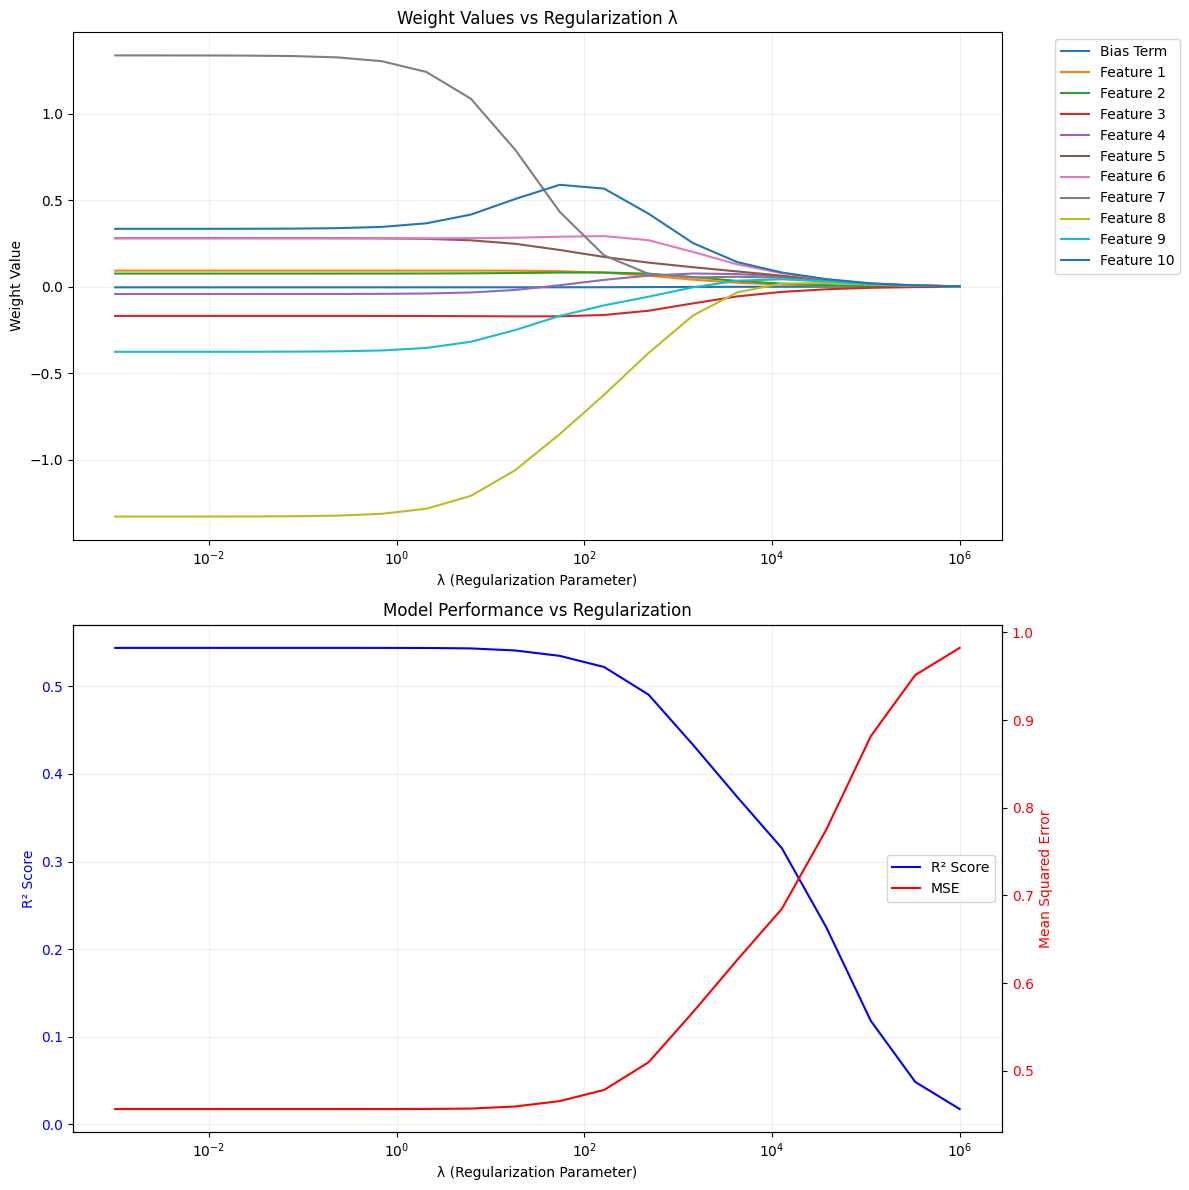

In [10]:
model = LinearRegression(X, y)
fig = model.plot_regularization_effects(lambda_range=(-3, 6), n_samples=20)

plt.show()

### 1.2.3. Cross-validation and general estimated error
The next step is to use the K-fold cross-validation to estimate the general error of the model.

In [11]:
def one_level_cross_validation(self, lambda_, K=10):
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    
    mse_scores = []
    
    for train_index, test_index in kf.split(self.X):
        X_train, X_test = self.X[train_index], self.X[test_index]
        y_train, y_test = self.y[train_index], self.y[test_index]
        
        fold_model = LinearRegression(X_train, y_train, include_bias=False)
        fold_model.solve_analytical(lambda_)
        
        y_pred = np.dot(X_test, fold_model.weights)
        
        mse = np.mean((y_test - y_pred) ** 2)
        
        mse_scores.append(mse)
        
        
    generalization_error = np.mean(mse_scores)
    
    return generalization_error

LinearRegression.one_level_cross_validation = one_level_cross_validation

In [12]:
def plot_one_level_cv_generalization_error(self, lambda_range=(-3, 6), num_lambdas=50, K=10):
    generalization_errors = [{
        'lambda': lambda_,
        'err': self.one_level_cross_validation(lambda_, K),   
    } for lambda_ in np.logspace(lambda_range[0], lambda_range[1], num_lambdas)]
    
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    
    opt_lambda = 1000
    lowest_mse = 1000
    
    for i in generalization_errors:
        if i['err'] < lowest_mse:
            lowest_mse = i['err']
            opt_lambda = i['lambda']
    print(f'Optimal lambda: {opt_lambda}')
    print(f'Lowest MSE: {lowest_mse}')
    
    ax.semilogx([r['lambda'] for r in generalization_errors], [r['err'] for r in generalization_errors], '-')
    ax.set_xlabel('lambda')
    ax.set_ylabel('Generalization error')
    ax.set_title('Generalization error vs. lambda')
    
    return fig
        
LinearRegression.plot_one_level_cv_generalization_error = plot_one_level_cv_generalization_error

Optimal lambda: 0.3727593720314942
Lowest MSE: 0.4592708553523062


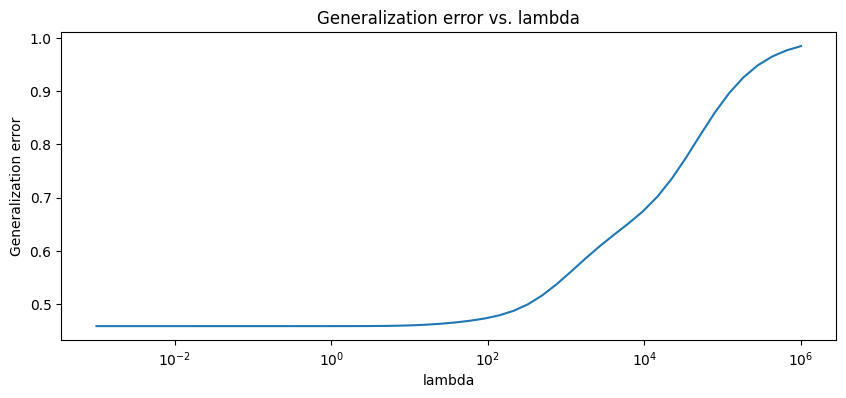

In [13]:
model = LinearRegression(X, y)
fig = model.plot_one_level_cv_generalization_error()
plt.show()

ExactExplainer explainer: 836it [00:12, 16.98it/s]                          


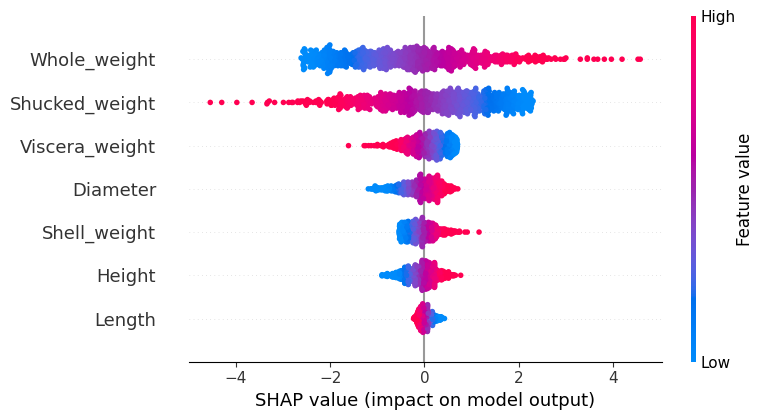

In [14]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
import pandas as pd

X_shap, y_shap = standardized_data[:, :-1], standardized_data[:, -1:]
y_shap = pd.Series(y_shap[:,0])

feature_names = ['Male', 'Female', 'Infant'] + abalone.variables.name.to_numpy()[1:-1].tolist()
#X_shap, y_shap = encoded_data[:, :-1], encoded_data[:, -1:]

X_shap = pd.DataFrame(X_shap, columns=feature_names)
for i in range(X_shap.shape[0]):
    X_shap.values[i, 0] = float(X_shap.values[i, 0])
    X_shap.values[i, 1] = float(X_shap.values[i, 1])
    X_shap.values[i, 2] = float(X_shap.values[i, 2])
    
for i in range(X_shap.shape[0]):
    for j in range(X_shap.shape[1]):
        assert isinstance(X_shap.values[i, j], (float))
        
X_train, X_test, y_train, y_test = train_test_split(X_shap, y_shap, test_size=0.2, random_state=42)

X_train = X_train.astype(float)
X_test = X_test.astype(float)


# a simple linear model
model = LR()
model.fit(X_train, y_train)

# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

# Select only attributes 3 to 10 (zero-indexed: 2 to 9)
selected_indices = slice(3, 10)  # This corresponds to columns 3 to 10

# Get the relevant SHAP values and feature names
shap_values_subset = shap_values[:, selected_indices]
X_test_subset = X_test.iloc[:, selected_indices]

# Plot SHAP values for the selected features
shap.summary_plot(shap_values_subset, X_test_subset, feature_names=X_test.columns[selected_indices])

In [15]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    # Calculates the normalized version
    importances_norm = softmax(importances)
    
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f}")

print_feature_importances_shap_values(shap_values, feature_names)

Male -> 491012791340.2504
Female -> 444973592855.9846
Infant -> 383036052440.0378
Whole_weight -> 1.1857
Shucked_weight -> 1.0915
Viscera_weight -> 0.3323
Diameter -> 0.2973
Shell_weight -> 0.2392
Height -> 0.2367
Length -> 0.0996


- - -
## 1.3. Considerations

### 1.3.1. 
Explain how the output, $y$, of the linear model with the lowest generalization error (as determined in the previous question) is computed for a given input $x$. 

### 1.3.2. 
What is the effect of an individual attribute in $x$ on the output, $y$, of the linear model?

### 1.3.3. 
Does the effect of individual attributes make sense based on your understanding of the problem?

- - -
- - -

# 2. Regression (part 2)

In this section, we will compare three models: the regularized linear regression model from the previous section, an artificial neural network (ANN) and a baseline. We are interested in two questions: Is one model better than the other? Is either model better than a trivial baseline?. We will attempt to answer these questions with two-level cross-validation.

## 2.1. Building the models

### 2.1.1. Baseline model

As a baseline, we will use a linear regression model without features, that predicts the output for each test data always as the average of the training data.

In [16]:
def predict_on_average(self, y):
    return np.mean(y)
    
LinearRegression.predict_on_average = predict_on_average

In [17]:
model = LinearRegression(X, y)
pred = model.predict_on_average(y)

print(pred)

2.1834652200092643e-16


### 2.1.2. Artificial Neural Networks (ANN)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class DataLoader:
    def __init__(self, data, targets, batch_size=32, shuffle=True):
        if isinstance(data, np.ndarray):
            self.data = torch.FloatTensor(data)
        else:
            self.data = data
            
        if isinstance(targets, np.ndarray):
            self.targets = torch.FloatTensor(targets)
        else:
            self.targets = targets
            
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_samples = len(data)
        
    def __iter__(self):
        self.index = 0

        self.indices = list(range(self.n_samples))
        if self.shuffle:
            np.random.shuffle(self.indices)

        return self
    
    def __next__(self):
        if self.index >= self.n_samples:
            raise StopIteration
            
        # Get indices for current batch
        batch_indices = self.indices[self.index:min(self.index + self.batch_size, self.n_samples)]
        
        # Get data and targets for current batch
        batch_data = self.data[batch_indices]
        batch_targets = self.targets[batch_indices]
        
        self.index += self.batch_size
        
        return batch_data, batch_targets
    
    def __len__(self):
        return (self.n_samples + self.batch_size - 1) // self.batch_size
    
    @property
    def dataset(self):
        return self.data

In [20]:
class ANNRegression(nn.Module):
    def __init__(self, input_size, hidden_neurons):
        super(ANNRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_neurons)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons, 1)
        
    def predict(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
    def train_(self, train_loader, test_loader, optimizer, criterion, num_epochs):
        test_losses = []
        
        for epoch in range(num_epochs):
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                
                optimizer.zero_grad()
                output = self.predict(data)
                
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                
                if batch_idx == train_loader.dataset.__len__():
                    print(
                        f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]',
                        f'Loss: {loss.item():.6f}'
                    )
                    
            self.eval()
            test_loss = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = self.predict(data)
                    test_loss += criterion(output, target).item()
                    
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)

- - -
## 2.2. Comparing the performance

### 2.2.1. Two-level cross-validation

In [30]:
import math
from tqdm import tqdm

batch_size = 128
num_epochs = 50
criterion = torch.nn.MSELoss()

def two_level_cross_validation(lambdas, hidden_neurons, outer_K, inner_K):
    baseline_outer_mse_scores = []
    lr_outer_mse_scores = []
    ann_outer_mse_scores = []
    
    outer_kf = KFold(n_splits=outer_K, shuffle=True, random_state=42)
    outer_progress = tqdm(outer_kf.split(X), desc="Outer Fold", total=outer_K)
    
    for outer_fold, (outer_train_index, outer_test_index) in enumerate(outer_progress):
        X_outer_train, X_outer_test = X[outer_train_index], X[outer_test_index]
        y_outer_train, y_outer_test = y[outer_train_index], y[outer_test_index]
        
        lr_lowest_inner_mse = np.inf
        best_lambda = None
        
        ann_lowest_inner_mse = np.inf
        best_hidden = None
        
        inner_kf = KFold(n_splits=inner_K, shuffle=True, random_state=42)
        inner_progress = tqdm(inner_kf.split(X_outer_train), desc=f"Outer Fold {outer_fold+1} - Inner Fold", total=inner_K, leave=False)
        
        for i, (inner_train_index, inner_val_index) in enumerate(inner_progress):
            X_inner_train, X_inner_val = X_outer_train[inner_train_index], X_outer_train[inner_val_index]
            y_inner_train, y_inner_val = y_outer_train[inner_train_index], y_outer_train[inner_val_index]
            
            # Train the linear regression model
            lambda_ = lambdas[i]
            lr_model = LinearRegression(X_inner_train, y_inner_train,include_bias=False)
            lr_model.solve_analytical(lambda_)
            lr_val_pred = np.dot(X_inner_val, lr_model.weights)
            lr_inner_mse = np.mean((y_inner_val - lr_val_pred) ** 2)
            if lr_inner_mse < lr_lowest_inner_mse:
                lr_lowest_inner_mse = lr_inner_mse
                best_lambda = lambda_
                
            # Train the ANN model
            X_inner_train = torch.Tensor(X_inner_train.astype(np.float64)).to(device)
            y_inner_train = torch.Tensor(y_inner_train.astype(np.float64)).to(device)
            X_inner_val = torch.Tensor(X_inner_val.astype(np.float64)).to(device)
            y_inner_val = torch.Tensor(y_inner_val.astype(np.float64)).to(device)
            
            train_loader = DataLoader(X_inner_train, y_inner_train, batch_size=batch_size)
            val_loader = DataLoader(X_inner_val, y_inner_val, batch_size=batch_size)

            hidden = hidden_neurons[i]
            ann_model = ANNRegression(X_inner_train.shape[1], hidden)
            ann_model.to(device)
            optimizer = torch.optim.Adam(ann_model.parameters(), lr=1e-3)
            
            ann_model.train_(train_loader, val_loader, optimizer, criterion, num_epochs)
            ann_val_pred = ann_model.predict(X_inner_val)
            ann_inner_mse = np.mean((y_inner_val.cpu().detach().numpy() - ann_val_pred.cpu().detach().numpy()) ** 2)
            if ann_inner_mse < ann_lowest_inner_mse:
                ann_lowest_inner_mse = ann_inner_mse
                best_hidden = hidden
                
        # Evaluate the baseline model
        baseline_model = LinearRegression(X_outer_train, y_outer_train, include_bias=False)
        baseline_test_pred = baseline_model.predict_on_average(y_outer_test)
        baseline_outer_mse = np.mean((y_outer_test - baseline_test_pred) ** 2)
        baseline_outer_mse_scores.append({
            'mse': baseline_outer_mse
        })
        
        # Train the outer linear regression model with the best lambda
        lr_model = LinearRegression(X_outer_train, y_outer_train, include_bias=False)
        lr_model.solve_analytical(best_lambda)
        # And evaluate it on the test set
        lr_test_pred = np.dot(X_outer_test, lr_model.weights)
        lr_outer_mse = np.mean((y_outer_test - lr_test_pred) ** 2)
        lr_outer_mse_scores.append({
            'lambda': best_lambda,
            'mse': lr_outer_mse
        })
        
        # Train the outer ANN model with the best number of hidden neurons
        X_outer_train = torch.Tensor(X_outer_train.astype(np.float64)).to(device)
        y_outer_train = torch.Tensor(y_outer_train.astype(np.float64)).to(device)
        X_outer_test = torch.Tensor(X_outer_test.astype(np.float64)).to(device)
        y_outer_test = torch.Tensor(y_outer_test.astype(np.float64)).to(device)
        
        train_loader = DataLoader(X_outer_train, y_outer_train, batch_size=batch_size)
        test_loader = DataLoader(X_outer_test, y_outer_test, batch_size=batch_size)

        hidden = hidden_neurons[i]
        ann_model = ANNRegression(X_outer_train.shape[1], hidden)
        ann_model.to(device)
        optimizer = torch.optim.Adam(ann_model.parameters(), lr=1e-3)
        
        ann_model.train_(train_loader, test_loader, optimizer, criterion, num_epochs)
        # And evaluate it on the test set
        ann_test_pred = ann_model.predict(X_outer_test)
        ann_outer_mse = np.mean((y_outer_test.cpu().detach().numpy() - ann_test_pred.cpu().detach().numpy()) ** 2)
        ann_outer_mse_scores.append({
            'hidden': best_hidden,
            'mse': ann_outer_mse
        })
        
    return baseline_outer_mse_scores, lr_outer_mse_scores, ann_outer_mse_scores

In [31]:
baseline_outer_mse_scores, lr_outer_mse_scores, ann_outer_mse_scores = two_level_cross_validation(
    lambdas=np.logspace(-3, 6, 10), 
    hidden_neurons=[int(math.pow(2, i)) for i in range(10)],  
    outer_K=10,
    inner_K=10,
)

print(baseline_outer_mse_scores)
print(lr_outer_mse_scores)
print(ann_outer_mse_scores)

Outer Fold: 100%|██████████| 10/10 [02:49<00:00, 16.93s/it]

[{'mse': np.float64(1.1529156097319972)}, {'mse': np.float64(1.1492764865793017)}, {'mse': np.float64(0.9117398925916228)}, {'mse': np.float64(0.7906691912825519)}, {'mse': np.float64(1.160343441019332)}, {'mse': np.float64(1.0074488643011068)}, {'mse': np.float64(1.0971784915163092)}, {'mse': np.float64(0.8592125643317036)}, {'mse': np.float64(0.9584025531607328)}, {'mse': np.float64(0.8978604424540638)}]
[{'lambda': np.float64(1000.0), 'mse': np.float64(0.6288039948730509)}, {'lambda': np.float64(0.001), 'mse': np.float64(0.4617803338846142)}, {'lambda': np.float64(0.1), 'mse': np.float64(0.4764801161466922)}, {'lambda': np.float64(0.1), 'mse': np.float64(0.3775790097027381)}, {'lambda': np.float64(1.0), 'mse': np.float64(0.60081363269742)}, {'lambda': np.float64(10.0), 'mse': np.float64(0.4389539774878684)}, {'lambda': np.float64(0.01), 'mse': np.float64(0.49150465571552043)}, {'lambda': np.float64(100.0), 'mse': np.float64(0.42540312915585754)}, {'lambda': np.float64(10.0), 'mse': 

### 2.2.2 Creating a table

In [ ]:
import pandas as pd
from IPython.display import display, HTML

# Create the main data structure
data = {
    'Outer fold i': list(range(1, 10)),
    'h<sub>i</sub><sup>*</sup>': [ann_outer_mse_scores[i]["hidden"] for i in range(1, 10)],
    'ANN E<sub>i</sub><sup>test</sup>': [ann_outer_mse_scores[i]["mse"] for i in range(1, 10)],
    'λ<sub>i</sub><sup>*</sup>': [lr_outer_mse_scores[i]["lambda"] for i in range(1, 10)],
    'LR E<sub>i</sub><sup>test</sup>': [lr_outer_mse_scores[i]["mse"] for i in range(1, 10)],
    'Baseline E<sub>i</sub><sup>test</sup>': [baseline_outer_mse_scores[i]["mse"] for i in range(1, 10)]
}

# Create main DataFrame
df = pd.DataFrame(data)

# Set display options for better formatting
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))
pd.set_option('display.max_columns', None)

# Style for centered text
style = """
<style>
    table {text-align: center !important;}
    th {text-align: center !important;}
    td {text-align: center !important;}
</style>
"""

# Display the main table with centered text
display(HTML(style + df.to_html(escape=False)))

# Create summary DataFrame
summary_data = {
    'ANN': [
        df['ANN E<sub>i</sub><sup>test</sup>'].min(),
        df['ANN E<sub>i</sub><sup>test</sup>'].mean(),
        df['ANN E<sub>i</sub><sup>test</sup>'].max()
    ],
    'Logistic Regression': [
        df['LR E<sub>i</sub><sup>test</sup>'].min(),
        df['LR E<sub>i</sub><sup>test</sup>'].mean(),
        df['LR E<sub>i</sub><sup>test</sup>'].max()
    ],
    'Baseline': [
        df['Baseline E<sub>i</sub><sup>test</sup>'].min(),
        df['Baseline E<sub>i</sub><sup>test</sup>'].mean(),
        df['Baseline E<sub>i</sub><sup>test</sup>'].max()
    ]
}

summary_df = pd.DataFrame(
    summary_data,
    index=['Best', 'Average', 'Worst']
)

print("\nSummary Statistics (Test Loss):")
display(HTML(style + summary_df.round(4).to_html()))

,Outer fold i,hi*,ANN Eitest,λi*,LR Eitest,Baseline Eitest
0,1,64,0.4111,0.0010,0.4618,1.1493
1,2,256,0.4638,0.1000,0.4765,0.9117
2,3,4,0.3423,0.1000,0.3776,0.7907
3,4,128,0.5473,1.0000,0.6008,1.1603
4,5,16,0.4214,10.0000,0.4390,1.0074
5,6,512,0.4523,0.0100,0.4915,1.0972
6,7,32,0.3956,100.0000,0.4254,0.8592
7,8,16,0.3346,10.0000,0.3862,0.9584
8,9,256,0.3926,10.0000,0.4479,0.8979



Summary Statistics (Test Loss):


,ANN,Logistic Regression,Baseline
Best,0.3346,0.3776,0.7907
Average,0.4179,0.4563,0.9813
Worst,0.5473,0.6008,1.1603


- - -
- - -

# 3. Classification

For classification, we will use the same setup as the first project, so we will use the gender as the target variable, since it's categroical, and the number of rings as a feature.

## 3.1. Baseline model

## 3.2. Logistic regression for classification

In [78]:
class LogisticRegression:
    def __init__(self, X, y, learning_rate=0.01, max_iterations=1000, tol=1e-4):
        self.X = X.astype(np.float64)
        self.y = y.astype(np.float64).reshape(-1, 1)  # Ensure y is a column vector
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tol = tol
        
        # Initialize weights with proper shape
        self.weights = np.zeros((X.shape[1], 1)) # Make weights a column vector
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # Clip to prevent overflow
    
    def fit(self):
        m = len(self.y)  # number of samples
        prev_loss = float('inf')
        
        for iteration in range(self.max_iterations):
            # Forward pass
            z = np.dot(self.X, self.weights)  # Shape: (m, 1)
            y_pred = self.sigmoid(z)  # Shape: (m, 1)
            
            # Compute loss (binary cross-entropy)
            loss = -np.mean(
                self.y * np.log(y_pred + 1e-15) + 
                (1 - self.y) * np.log(1 - y_pred + 1e-15)
            )
            
            # Check convergence
            if abs(prev_loss - loss) < self.tol:
                print(f"Converged after {iteration} iterations")
                break
            prev_loss = loss
            
            if iteration % 100 == 0:
                print(f"Iteration {iteration}, Loss: {loss}")
            
            # Compute gradients - shape will be (n_features, 1)
            gradient = (1 / m) * np.dot(self.X.T, (y_pred - self.y))
            
            # Update weights - shapes match now
            self.weights -= self.learning_rate * gradient
    
    def predict_probability(self, X=None):
        if X is None:
            X = self.X
        return self.sigmoid(np.dot(X, self.weights))
    
    def predict(self, X=None, threshold=0.5):
        probas = self.predict_probability(X)
        return (probas >= threshold).astype(int)
    
    def score(self):
        y_pred = self.predict()
        
        # Accuracy
        accuracy = np.mean(y_pred == self.y)
        
        # Confusion matrix elements
        tp = np.sum((y_pred == 1) & (self.y == 1))
        tn = np.sum((y_pred == 0) & (self.y == 0))
        fp = np.sum((y_pred == 1) & (self.y == 0))
        fn = np.sum((y_pred == 0) & (self.y == 1))
        
        # Precision, Recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        }
        
        print("\nMetrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
            
        return metrics

In [79]:
model = LogisticRegression(X, y)
model.fit()
model.score()

Iteration 0, Loss: 0.6931471805599435
Iteration 100, Loss: -0.24908138228416088
Iteration 200, Loss: -0.6757178851257865
Iteration 300, Loss: -1.0307335904487753
Iteration 400, Loss: -1.3593300246787192
Iteration 500, Loss: -1.6747849299389197
Iteration 600, Loss: -1.9826350673088469
Iteration 700, Loss: -2.2856498707127795
Iteration 800, Loss: -2.585364420200652
Iteration 900, Loss: -2.8823123022964405

Metrics:
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1: 0.0000


{'Accuracy': np.float64(0.0), 'Precision': 0, 'Recall': 0, 'F1': 0}

## 3.3. ANN, KNN, NB or CT

In [80]:
class ANNClassification(nn.Module):
    def __init__(self, input_size, hidden_neurons):
        super(ANNClassification, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_neurons)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def predict(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
    
    def train_(self, train_loader, test_loader, optimizer, criterion, num_epochs):
        test_losses = []
        
        for epoch in range(num_epochs):
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                
                optimizer.zero_grad()
                output = self.predict(data)
                
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                
                if batch_idx == train_loader.dataset.__len__():
                    print(
                        f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]',
                        f'Loss: {loss.item():.6f}'
                    )
                    
            self.eval()
            test_loss = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = self.predict(data)
                    test_loss += criterion(output, target).item()
                    
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            
        fig = plt.figure(figsize=(10, 5))
        plt.plot(test_losses)
        plt.title('Loss vs. epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

- - -
- - -
# Exercises

### Exercise 1
The subplot that corresponds to the ROC curve is C, because decreasing the threshold starting from $1.0$, the first point that become predicted as poisitve is a true positive, so the ROC curve moves up, then we have two points that become predicted as positive, but are in fact false positives, so the ROC curve moves right twice, and so on, tracing the curve in the figure.

### Exercise 2
The impurity gain of the split is $\Delta\approx 0.0148$, because:

$$
\begin{align}
\Delta
&=I(r)-\displaystyle\sum_{i=1}^K\frac{N_i}{N}I(v_i)=\\
&=\left(1-\dfrac{37}{37+31+33+34}\right)-\left[\dfrac{120}{135}\left(1-\dfrac{33}{33+28+30+29}\right)+\dfrac{14}{135}\left(1-\dfrac5{4+2+3+5}\right)+\dfrac1{135}\left(1-\dfrac11\right)\right]=\\
&=\dfrac{98}{135}-\left[\dfrac{120}{135}\dfrac{87}{120}+\dfrac{14}{135}\dfrac{9}{14}+\dfrac{1}{135}\cdot0\right]=\\
&=\dfrac{98}{135}-\dfrac{96}{135}=\\
&=\dfrac2{135}\approx0.0148
\end{align}
$$

### Exercise 3
The network contains $110$ parameters, because the input layer has $7$ neurons, the hidden layer has $10$ neurons, and the output layer has $4$ neurons, so the weights are $7\times 10+10\times 4=110$.

### Exercise 4
The correct rules assignment to the nodes are the ones described in D, because A separates $b_1<-0.76$ from $b_1>-0.76$, B separates the top-left region (congestion level 2) from the bottom-left region (congestion level 1), then C separates the right-most region (congestion level 4) from the middle strip, which is finally separated by D into middle-top (congestion level 1) and middle-bottom (congestion level 3).

### Exercise 5


### Exercise 6
The observation assigned to class $y=4$ will be observation B, because:
- $\hat y_1=\begin{bmatrix}1\\-0.6\\-1.6\end{bmatrix}^T\begin{bmatrix}1.2\\-2.1\\3.2\end{bmatrix}=-2.66$
- $\hat y_2=\begin{bmatrix}1\\-0.6\\-1.6\end{bmatrix}^T\begin{bmatrix}1.2\\-1.7\\2.9\end{bmatrix}=-2.42$
- $\hat y_3=\begin{bmatrix}1\\-0.6\\-1.6\end{bmatrix}^T\begin{bmatrix}1.3\\-1.1\\2.2\end{bmatrix}=-1.56$

So $P(y=4|\hat{\textbf{y}})=\dfrac1{1+e^{-2.66}+e^{-2.42}+e^{-1.56}}\approx0.74$ (being more than $0.5$ makes useless to calculate the probability of the other classes).

- - -
- - -